# Alfa Lima Victor Project


In [1]:
from google.cloud import bigquery #--> paquetería para traer datos de bigquery
import pandas as pd # --> manipulación de dataframe
import pandas_gbq # --> conversión de un query a dataframe
import os # --> autenticación de cuenta google cloud

#### Carga de base búsquedas y compras

In [2]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] ='C:/Users/lzertu02/Documents/Curso Python/ModuloIII/my_key.json' #--> llave para autenticación a BQ
project_id = 'aeromexico-fb-project' #--> nombre de proyecto en cloud

In [3]:
client = bigquery.Client(project=project_id) # --> dirección del proyecto de cloud
compras_table = 'aeromexico-fb-project.17613923.ga_sessions_' #--> tabla de bigquery a la que se conecta para la extracción del dataframe

job_config = bigquery.QueryJobConfig(destination=compras_table)

query_compras = '''
SELECT
           clientId AS ClientId,
           date01 AS date,
           transactionID1 AS PNR,
           ProductName1 AS productName,
           productCategory1 AS productCategory,
           SUM(productRevenue1/1000000) AS productRevenue,
           SUM(productQuantity1) AS productQuantity
           FROM (
           SELECT
           clientId,
           LEFT(date,4)+'-'+SUBSTR(date,5,2)+'-'+RIGHT(date,2) AS date01,
           hits.transaction.transactionId AS transactionID1,
           hits.product.v2ProductName AS ProductName1,
           hits.product.v2productCategory AS productCategory1,
           hits.product.productRevenue AS productRevenue1,
           hits.product.productQuantity AS productQuantity1,
           hits.transaction.affiliation AS purchasePlace1,
           hits.transaction.currencyCode AS currencyCode1, 
           geoNetwork.country AS Country,
           MAX(IF (hits.customDimensions.index = 26, hits.customDimensions.value, NULL)) WITHIN RECORD AS dimension26,
           FROM
           TABLE_DATE_RANGE([aeromexico-fb-project:17613923.ga_sessions_], 
           DATE_ADD(CURRENT_TIMESTAMP(), -90, 'DAY'),
           DATE_ADD(CURRENT_TIMESTAMP(), -1, 'DAY'))
           WHERE
           hits.transaction.transactionRevenue > 0
           AND hits.transaction.affiliation LIKE 'Booking')
           WHERE
           REGEXP_MATCH(productCategory1,'^Flight/.*')
           GROUP BY
           ClientId,
           date,
           PNR,
           productName,
           productCategory
           ORDER BY
           ClientId,
           date
'''

compras= pandas_gbq.read_gbq(query_compras, project_id = project_id, dialect = "legacy")

Downloading: 100%|████████████████| 390622/390622 [00:31<00:00, 12565.93rows/s]


In [4]:
compras.head()

,ClientId,date,PNR,productName,productCategory,productRevenue,productQuantity
0,1000000318.1582685250,2020-02-26,VLFQAB-202002262000,Round Trip,Flight/Flight/BCN-MTY/1ADT:0CHD:1INF|202010171...,471.550954,2
1,1000000318.1582685250,2020-02-26,VLFQAB-202002262000,Round Trip,Flight/Flight/MTY-BCN/1ADT:0CHD:1INF|202009291...,471.550954,2
2,1000001190.1583987242,2020-03-11,XHDWQZ-202003112235,Round Trip,Flight/Flight/TRC-MEX/1ADT:0CHD:0INF|202003171...,12.444230,1
3,1000001190.1583987242,2020-03-11,XHDWQZ-202003112235,Round Trip,Flight/Flight/MEX-TRC/1ADT:0CHD:0INF|202003151...,12.444230,1
4,100001395.1461122683,2020-02-14,AEXHRC-202002142223,Round Trip,Flight/Flight/YUL-MEX/1ADT:0CHD:0INF|202004142...,186.568471,1


### Query Búsquedas 

In [5]:
client = bigquery.Client(project=project_id)   # --> dirección del proyecto de cloud
busquedas_table = 'aeromexico-fb-project.17613923.ga_sessions_' #--> tabla de bigquery a la que se conecta para la extracción del dataframe

job_config = bigquery.QueryJobConfig(destination=busquedas_table)

query_busquedas = '''
SELECT
                       date as Date,
                       clientId,
                       bookingEngine,
                       EXACT_COUNT_DISTINCT(sessions) as sessions
                       
                       FROM
                       (
                       Select 
                       date,
                       concat(fullvisitorid, cast(visitid as string)) as sessions,
                       MAX(IF (hits.customDimensions.index = 27, hits.customDimensions.value, NULL)) WITHIN RECORD AS clientId,
                       hits.eventInfo.eventAction as Event_Action,
                       hits.eventInfo.eventLabel AS bookingEngine
                       FROM
                       FLATTEN ( ( SELECT *
                       FROM TABLE_DATE_RANGE([aeromexico-fb-project:17613923.ga_sessions_],
                       DATE_ADD(CURRENT_TIMESTAMP(),-90,'DAY'),
                       DATE_ADD(CURRENT_TIMESTAMP(),-1, 'DAY'))), hits.eventInfo.eventAction)
                       WHERE
                       REGEXP_MATCH(hits.eventInfo.eventAction, 'Site Search 2')
                       AND clientId IS NOT NULL
                       AND totals.visits = 1)
                       Group by Date, clientId, bookingEngine
                       ORDER BY
                       clientId
'''

busquedas= pandas_gbq.read_gbq(query_busquedas, project_id = project_id, dialect = "legacy")

Downloading: 100%|██████████████| 5556201/5556201 [03:55<00:00, 23637.68rows/s]


## ETL:

#### ETL de Compras 

In [6]:
# Separación por columnas "Category":
new_cols = compras["productCategory"].str.split("/", n = 11, expand = True)

In [7]:
compras.head()

,ClientId,date,PNR,productName,productCategory,productRevenue,productQuantity
0,1000000318.1582685250,2020-02-26,VLFQAB-202002262000,Round Trip,Flight/Flight/BCN-MTY/1ADT:0CHD:1INF|202010171...,471.550954,2
1,1000000318.1582685250,2020-02-26,VLFQAB-202002262000,Round Trip,Flight/Flight/MTY-BCN/1ADT:0CHD:1INF|202009291...,471.550954,2
2,1000001190.1583987242,2020-03-11,XHDWQZ-202003112235,Round Trip,Flight/Flight/TRC-MEX/1ADT:0CHD:0INF|202003171...,12.444230,1
3,1000001190.1583987242,2020-03-11,XHDWQZ-202003112235,Round Trip,Flight/Flight/MEX-TRC/1ADT:0CHD:0INF|202003151...,12.444230,1
4,100001395.1461122683,2020-02-14,AEXHRC-202002142223,Round Trip,Flight/Flight/YUL-MEX/1ADT:0CHD:0INF|202004142...,186.568471,1


In [8]:
new_cols.head()

,0,1,2,3,4
0,Flight,Flight,BCN-MTY,1ADT:0CHD:1INF|202010171405:202010172350|COACH...,Europe
1,Flight,Flight,MTY-BCN,1ADT:0CHD:1INF|202009291441:202009301205|COACH...,Europe
2,Flight,Flight,TRC-MEX,1ADT:0CHD:0INF|202003171930:202003172120|COACH...,Domestic
3,Flight,Flight,MEX-TRC,1ADT:0CHD:0INF|202003151655:202003151855|COACH...,Domestic
4,Flight,Flight,YUL-MEX,1ADT:0CHD:0INF|202004142310:202004150410|COACH...,Transborder CA


In [9]:
# Creación de nuevas columnas.
compras["route"]= new_cols[2]
compras["category2"]= new_cols[3]
compras["region_bf"]= new_cols[4]

In [10]:
compras.head(3)

,ClientId,date,PNR,productName,productCategory,productRevenue,productQuantity,route,category2,region_bf
0,1000000318.1582685250,2020-02-26,VLFQAB-202002262000,Round Trip,Flight/Flight/BCN-MTY/1ADT:0CHD:1INF|202010171...,471.550954,2,BCN-MTY,1ADT:0CHD:1INF|202010171405:202010172350|COACH...,Europe
1,1000000318.1582685250,2020-02-26,VLFQAB-202002262000,Round Trip,Flight/Flight/MTY-BCN/1ADT:0CHD:1INF|202009291...,471.550954,2,MTY-BCN,1ADT:0CHD:1INF|202009291441:202009301205|COACH...,Europe
2,1000001190.1583987242,2020-03-11,XHDWQZ-202003112235,Round Trip,Flight/Flight/TRC-MEX/1ADT:0CHD:0INF|202003171...,12.444230,1,TRC-MEX,1ADT:0CHD:0INF|202003171930:202003172120|COACH...,Domestic


In [11]:
#Desagregación de "Category" por Pasajero, fecha, familia tarifaria, tipo de vuelo".
new_cols = compras["category2"].str.split("|", n = 10, expand = True)
new_cols.head()

,0,1,2,3,4
0,1ADT:0CHD:1INF,202010171405:202010172350,COACH_BA,RT-VUELTA,38:964
1,1ADT:0CHD:1INF,202009291441:202009301205,COACH_BA,RT-IDA,933:37
2,1ADT:0CHD:0INF,202003171930:202003172120,COACH_BA,RT-VUELTA,109
3,1ADT:0CHD:0INF,202003151655:202003151855,COACH_BA,RT-IDA,106
4,1ADT:0CHD:0INF,202004142310:202004150410,COACH_BA,RT-VUELTA,637


In [12]:
compras.head(2)

,ClientId,date,PNR,productName,productCategory,productRevenue,productQuantity,route,category2,region_bf
0,1000000318.1582685250,2020-02-26,VLFQAB-202002262000,Round Trip,Flight/Flight/BCN-MTY/1ADT:0CHD:1INF|202010171...,471.550954,2,BCN-MTY,1ADT:0CHD:1INF|202010171405:202010172350|COACH...,Europe
1,1000000318.1582685250,2020-02-26,VLFQAB-202002262000,Round Trip,Flight/Flight/MTY-BCN/1ADT:0CHD:1INF|202009291...,471.550954,2,MTY-BCN,1ADT:0CHD:1INF|202009291441:202009301205|COACH...,Europe


In [13]:

# Adición de nuevas colomunas obtenidas de "Category" al Dataframe
compras["paxs"]= new_cols[0]
compras["flighDates"]= new_cols[1]
compras["familyFare"]= new_cols[2]
compras["flightType"]= new_cols[3]
compras.drop(columns =["productCategory", "category2"], inplace = True) 
new_cols = compras["flighDates"].str.split(":", n = 2, expand = True)
compras["flightDate"] = new_cols[0]
compras.drop(columns =["flighDates"], inplace = True) 
new_cols = compras["route"].str.split("-", n = 2, expand = True)
compras["origin"] = new_cols[0]
compras["destination"] = new_cols[1]
compras.head(2)


,ClientId,date,PNR,productName,productRevenue,productQuantity,route,region_bf,paxs,familyFare,flightType,flightDate,origin,destination
0,1000000318.1582685250,2020-02-26,VLFQAB-202002262000,Round Trip,471.550954,2,BCN-MTY,Europe,1ADT:0CHD:1INF,COACH_BA,RT-VUELTA,202010171405,BCN,MTY
1,1000000318.1582685250,2020-02-26,VLFQAB-202002262000,Round Trip,471.550954,2,MTY-BCN,Europe,1ADT:0CHD:1INF,COACH_BA,RT-IDA,202009291441,MTY,BCN


In [14]:
compras["flightDate"] =pd.to_datetime(compras["flightDate"])  # --> Cambio en el formato de fecha de "flightDate" 
compras.head()

,ClientId,date,PNR,productName,productRevenue,productQuantity,route,region_bf,paxs,familyFare,flightType,flightDate,origin,destination
0,1000000318.1582685250,2020-02-26,VLFQAB-202002262000,Round Trip,471.550954,2,BCN-MTY,Europe,1ADT:0CHD:1INF,COACH_BA,RT-VUELTA,2020-10-17 14:05:00,BCN,MTY
1,1000000318.1582685250,2020-02-26,VLFQAB-202002262000,Round Trip,471.550954,2,MTY-BCN,Europe,1ADT:0CHD:1INF,COACH_BA,RT-IDA,2020-09-29 14:41:00,MTY,BCN
2,1000001190.1583987242,2020-03-11,XHDWQZ-202003112235,Round Trip,12.444230,1,TRC-MEX,Domestic,1ADT:0CHD:0INF,COACH_BA,RT-VUELTA,2020-03-17 19:30:00,TRC,MEX
3,1000001190.1583987242,2020-03-11,XHDWQZ-202003112235,Round Trip,12.444230,1,MEX-TRC,Domestic,1ADT:0CHD:0INF,COACH_BA,RT-IDA,2020-03-15 16:55:00,MEX,TRC
4,100001395.1461122683,2020-02-14,AEXHRC-202002142223,Round Trip,186.568471,1,YUL-MEX,Transborder CA,1ADT:0CHD:0INF,COACH_BA,RT-VUELTA,2020-04-14 23:10:00,YUL,MEX


#### ETL de Búsquedas

In [15]:
# Separación del "bookingEngine	"por Columna
busquedas = busquedas.dropna()
busquedas = busquedas.reset_index()
new_cols = busquedas["bookingEngine"].str.split("|", n = 2, expand = True)
new_cols.head(2)

,0,1
0,HMO,MTY
1,MTY,HMO


In [16]:
# Creación de la columna por origen y destuno
busquedas["origin"] = new_cols[0]
busquedas["destination"] = new_cols[1]
busquedas.head(5)

,index,Date,clientId,bookingEngine,sessions,origin,destination
0,93258,20200310,1000000260.1583885860,HMO | MTY,1,HMO,MTY
1,93259,20200310,1000000260.1583885860,MTY | HMO,1,MTY,HMO
2,93260,20200225,1000000318.1582685250,MTY | BCN,1,MTY,BCN
3,93261,20200226,1000000318.1582685250,MTY | BCN,1,MTY,BCN
4,93262,20200417,1000000681.1587154845,MXL | DEL,1,MXL,DEL


In [17]:
#Cambio en el formato de fecha de "Date"
busquedas["Date"] =pd.to_datetime(busquedas["Date"])
busquedas["destination"] = busquedas["destination"].str.strip()
busquedas.head(5)

,index,Date,clientId,bookingEngine,sessions,origin,destination
0,93258,2020-03-10,1000000260.1583885860,HMO | MTY,1,HMO,MTY
1,93259,2020-03-10,1000000260.1583885860,MTY | HMO,1,MTY,HMO
2,93260,2020-02-25,1000000318.1582685250,MTY | BCN,1,MTY,BCN
3,93261,2020-02-26,1000000318.1582685250,MTY | BCN,1,MTY,BCN
4,93262,2020-04-17,1000000681.1587154845,MXL | DEL,1,MXL,DEL


## Join con el catálogo de regiones (búsquedas)


In [18]:
client = bigquery.Client(project=project_id) # --> dirección del proyecto de cloud
Cat_table = 'aeromexico-fb-project.Catalogs.catalog_rout_complet' #--> tabla de bigquery a la que se conecta para la extracción del dataframe

 

job_config = bigquery.QueryJobConfig(destination=Cat_table)

 

query_cat ='''
SELECT distinct * FROM `aeromexico-fb-project.Catalogs.catalog_rout_complet` '''


catRegions= pandas_gbq.read_gbq(query_cat, project_id = project_id, dialect = "standard")

Downloading: 100%|██████████████████| 58755/58755 [00:01<00:00, 33923.21rows/s]


In [19]:
catRegions.head()

,D_O,MKT,REGION
0,CJS-MLM,DOM,FRO
1,CJS-ZCL,DOM,FRO
2,CME-MXL,DOM,FRO
3,CUU-MAM,DOM,FRO
4,HMO-REX,DOM,FRO


In [20]:
# Para quitar el espacio de booking engine
busquedas["origin"] = busquedas["origin"].str.strip()
busquedas["destination"] = busquedas["destination"].str.strip()

#Concatenar el origen y destino para join con regiones 
busquedas['D_O']=busquedas['origin']+'-'+busquedas['destination']

#eliminar booking engine
busquedas.drop(columns =["bookingEngine","index"], inplace = True) 


busquedas.head()

,Date,clientId,sessions,origin,destination,D_O
0,2020-03-10,1000000260.1583885860,1,HMO,MTY,HMO-MTY
1,2020-03-10,1000000260.1583885860,1,MTY,HMO,MTY-HMO
2,2020-02-25,1000000318.1582685250,1,MTY,BCN,MTY-BCN
3,2020-02-26,1000000318.1582685250,1,MTY,BCN,MTY-BCN
4,2020-04-17,1000000681.1587154845,1,MXL,DEL,MXL-DEL


In [25]:
# Join con base de búsquedas por D_O
busquedas = busquedas.merge(catRegions, left_on = 'D_O', right_on = 'D_O')
#reenombrar las columnas
busquedas.columns = ['Date','clientId','sessions','origenBuscado','destinoBuscado','D_O','MKT','REGION']
#eliminar la columna D_O
busquedas.drop(columns =["D_O"], inplace = True) 
busquedas.head(5)

,Date,clientId,sessions,origenBuscado,destinoBuscado,MKT,REGION
0,2020-03-10,1000000260.1583885860,1,HMO,MTY,DOM,LOC
1,2020-02-26,1000251101.1582782335,1,HMO,MTY,DOM,LOC
2,2020-02-18,100053376.1563315526,2,HMO,MTY,DOM,LOC
3,2020-03-11,1000575086.1583974231,2,HMO,MTY,DOM,LOC
4,2020-04-11,1000691603.1586651481,1,HMO,MTY,DOM,LOC


## Join con el catálogo de regiones (compras)


In [27]:
compras.head()

,ClientId,date,PNR,productName,productRevenue,productQuantity,route,region_bf,paxs,familyFare,flightType,flightDate,origin,destination
0,1000000318.1582685250,2020-02-26,VLFQAB-202002262000,Round Trip,471.550954,2,BCN-MTY,Europe,1ADT:0CHD:1INF,COACH_BA,RT-VUELTA,2020-10-17 14:05:00,BCN,MTY
1,1000000318.1582685250,2020-02-26,VLFQAB-202002262000,Round Trip,471.550954,2,MTY-BCN,Europe,1ADT:0CHD:1INF,COACH_BA,RT-IDA,2020-09-29 14:41:00,MTY,BCN
2,1000001190.1583987242,2020-03-11,XHDWQZ-202003112235,Round Trip,12.444230,1,TRC-MEX,Domestic,1ADT:0CHD:0INF,COACH_BA,RT-VUELTA,2020-03-17 19:30:00,TRC,MEX
3,1000001190.1583987242,2020-03-11,XHDWQZ-202003112235,Round Trip,12.444230,1,MEX-TRC,Domestic,1ADT:0CHD:0INF,COACH_BA,RT-IDA,2020-03-15 16:55:00,MEX,TRC
4,100001395.1461122683,2020-02-14,AEXHRC-202002142223,Round Trip,186.568471,1,YUL-MEX,Transborder CA,1ADT:0CHD:0INF,COACH_BA,RT-VUELTA,2020-04-14 23:10:00,YUL,MEX


In [28]:
#eliminar columnas que no necesitamos
compras.drop(columns =["PNR","productRevenue","region_bf","paxs","flightDate"], inplace = True) 
#Concatenar el origen y destino para join con regiones 
compras['D_O']=compras['origin']+'-'+compras['destination']
# Join con base de búsquedas por D_O
compras = compras.merge(catRegions, left_on = 'D_O', right_on = 'D_O')
#eliminar columnas
compras.drop(columns =["route","D_O"], inplace = True) 
#reenombrar las columnas
compras.columns = ['ClientId','fechaComprada','productName','productQuantity','FFComprada','flightType','origenComprado','destinoComprado','mktCompra','regionCompra']
#filtrar por puro RT Vuelta y One Way
compras = compras[compras['flightType'] != "RT-VUELTA"]
compras.head(5)

,ClientId,fechaComprada,productName,productQuantity,FFComprada,flightType,origenComprado,destinoComprado,mktCompra,regionCompra
5,1064470544.1582792605,2020-02-29,Round Trip,1,COACH_CL,RT-IDA,BCN,MTY,INT,EUR
7,1086056095.1587021069,2020-04-16,Round Trip,1,COACH_CL,RT-IDA,BCN,MTY,INT,EUR
10,1174393130.1584800378,2020-03-21,Round Trip,1,COACH_CL,RT-IDA,BCN,MTY,INT,EUR
11,1183007723.1582231987,2020-03-10,Round Trip,2,COACH_CL,RT-IDA,BCN,MTY,INT,EUR
12,1185247689.1588989469,2020-05-08,Round Trip,1,COACH_CL,RT-IDA,BCN,MTY,INT,EUR


## Join de Base de Compras con Base de Búsquedas (by ClientId)

In [29]:
# Join con base por ClientId
busquedasCompras = busquedas.merge(compras, left_on = 'clientId', right_on = 'ClientId')
busquedasCompras.head(5)

,Date,clientId,sessions,origenBuscado,destinoBuscado,MKT,REGION,ClientId,fechaComprada,productName,productQuantity,FFComprada,flightType,origenComprado,destinoComprado,mktCompra,regionCompra
0,2020-04-27,1001826687.1562863880,1,HMO,MTY,DOM,LOC,1001826687.1562863880,2020-04-22,Round Trip,1,COACH_CL,RT-IDA,HMO,MEX,DOM,LOC
1,2020-04-27,1001826687.1562863880,1,HMO,MTY,DOM,LOC,1001826687.1562863880,2020-04-20,One Way,1,COACH_AM,OW,BJX,HMO,DOM,LOC
2,2020-04-27,1001826687.1562863880,1,HMO,MTY,DOM,LOC,1001826687.1562863880,2020-04-22,One Way,1,COACH_CL,OW,BJX,HMO,DOM,LOC
3,2020-04-20,1001826687.1562863880,1,HMO,MTY,DOM,LOC,1001826687.1562863880,2020-04-22,Round Trip,1,COACH_CL,RT-IDA,HMO,MEX,DOM,LOC
4,2020-04-20,1001826687.1562863880,1,HMO,MTY,DOM,LOC,1001826687.1562863880,2020-04-20,One Way,1,COACH_AM,OW,BJX,HMO,DOM,LOC


In [30]:
busquedasCompras['coincide'] = busquedasCompras.apply(lambda x : True if  x['destinoBuscado'] == x['destinoComprado'] else False, axis=1) 


In [31]:
busquedasCompras.head(100)

,Date,clientId,sessions,origenBuscado,destinoBuscado,MKT,REGION,ClientId,fechaComprada,productName,productQuantity,FFComprada,flightType,origenComprado,destinoComprado,mktCompra,regionCompra,coincide
0,2020-04-27,1001826687.1562863880,1,HMO,MTY,DOM,LOC,1001826687.1562863880,2020-04-22,Round Trip,1,COACH_CL,RT-IDA,HMO,MEX,DOM,LOC,False
1,2020-04-27,1001826687.1562863880,1,HMO,MTY,DOM,LOC,1001826687.1562863880,2020-04-20,One Way,1,COACH_AM,OW,BJX,HMO,DOM,LOC,False
2,2020-04-27,1001826687.1562863880,1,HMO,MTY,DOM,LOC,1001826687.1562863880,2020-04-22,One Way,1,COACH_CL,OW,BJX,HMO,DOM,LOC,False
3,2020-04-20,1001826687.1562863880,1,HMO,MTY,DOM,LOC,1001826687.1562863880,2020-04-22,Round Trip,1,COACH_CL,RT-IDA,HMO,MEX,DOM,LOC,False
4,2020-04-20,1001826687.1562863880,1,HMO,MTY,DOM,LOC,1001826687.1562863880,2020-04-20,One Way,1,COACH_AM,OW,BJX,HMO,DOM,LOC,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2020-03-11,1005650223.1481322296,1,HMO,MTY,DOM,LOC,1005650223.1481322296,2020-03-13,One Way,1,COACH_CL,OW,QRO,MTY,DOM,LOC,True
96,2020-03-11,1005650223.1481322296,1,HMO,MTY,DOM,LOC,1005650223.1481322296,2020-02-11,One Way,1,COACH_CL,OW,MTY,QRO,DOM,LOC,False
97,2020-03-11,1005650223.1481322296,1,HMO,MTY,DOM,LOC,1005650223.1481322296,2020-03-04,One Way,1,COACH_CL,OW,MTY,QRO,DOM,LOC,False
98,2020-03-11,1005650223.1481322296,1,HMO,MTY,DOM,LOC,1005650223.1481322296,2020-03-11,One Way,1,COACH_CL,OW,MTY,QRO,DOM,LOC,False


In [1]:
#Guardado en un csv el resultado
busquedasCompras.to_csv('busquedasCompras.csv')

# Análisis Exploratorio de Datos


In [4]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

c:\users\lzertu02\appdata\local\continuum\miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (2,8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


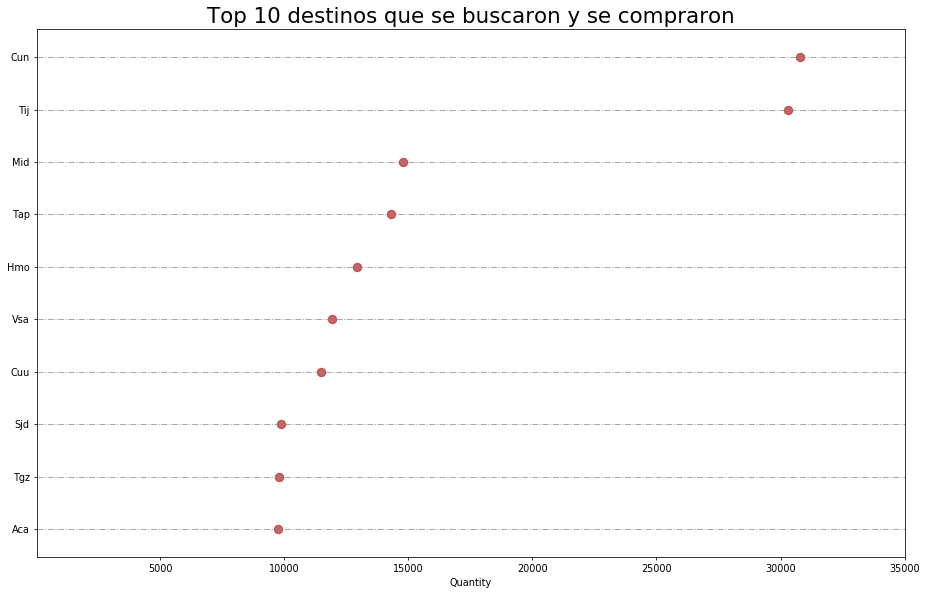

In [5]:
#Gráfica para traer el top 10 de destinos que se buscaron y se compraron 

df=pd.read_csv('busquedasCompras.csv')

#traer nada más lo que necesitamos
topCoincide=df[['destinoComprado','coincide']]

#filtro para traer solo los destinos que se buscaron y se compraron
topCoincide = topCoincide[topCoincide['coincide'] == True]
#eliminar columna
topCoincide.drop(columns =["coincide"], inplace = True) 

#buscar hacer un contador
topCoincide=topCoincide.groupby('destinoComprado').size().reset_index(name='counts')
#acomodarlo de mayor a menor
topCoincide=topCoincide.sort_values('counts',ascending=False)
#Excluír el tríangulo de negocios MTY GDL MEX
topCoincide=topCoincide[topCoincide['destinoComprado'] != "MEX"]
topCoincide=topCoincide[topCoincide['destinoComprado'] != "MTY"]
topCoincide=topCoincide[topCoincide['destinoComprado'] != "GDL"]
#traer el top 10
topCoincide=topCoincide.head(10)
topCoincide.head()

dotTop = topCoincide[['counts', 'destinoComprado']].groupby('destinoComprado').apply(lambda x: x.mean())
dotTop.sort_values('counts', inplace=True)
dotTop.reset_index(inplace=True)

fig, ax = plt.subplots(figsize=(16,10), dpi= 70)
ax.hlines(y=dotTop.index, xmin=10, xmax=35000, color='gray', alpha=0.7, linewidth=1, linestyles='dashdot')
ax.scatter(y=dotTop.index, x=dotTop.counts, s=75, color='firebrick', alpha=0.7)

ax.set_title('Top 10 destinos que se buscaron y se compraron', fontdict={'size':22})
ax.set_xlabel('Quantity')
ax.set_yticks(dotTop.index)
ax.set_yticklabels(dotTop.destinoComprado.str.title(), fontdict={'horizontalalignment': 'right'})
ax.set_xlim(10,35000)
plt.show()


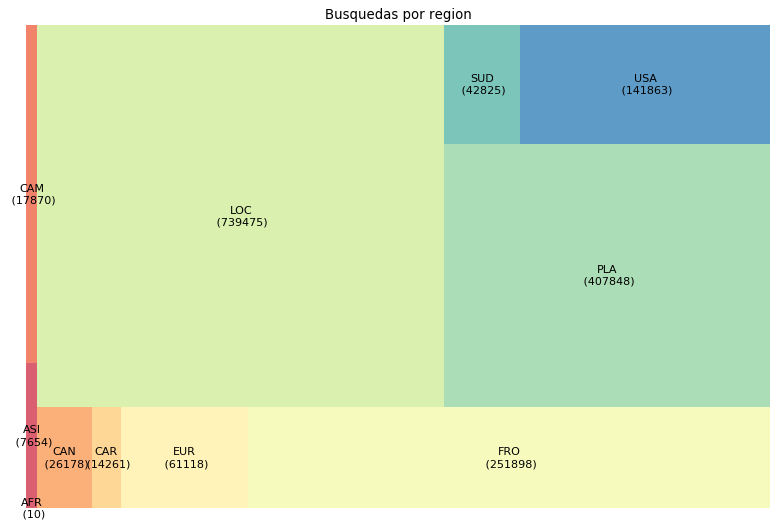

In [8]:
#Mapa de árbol que trae las búsquedas por región

import squarify

df=pd.read_csv('busquedasCompras.csv')

#Gráfica para búsquedas por región
# Prepare Data
df_group2 = df.groupby('REGION').size().reset_index(name='busquedas')
labels = df_group2.apply(lambda x: str(x[0]) + "\n (" + str(x[1]) + ")", axis=1)
sizes = df_group2['busquedas'].values.tolist()
colors = [plt.cm.Spectral(i/float(len(labels))) for i in range(len(labels))]

# Draw Plot
plt.figure(figsize=(12,8), dpi= 80)
squarify.plot(sizes=sizes, label=labels, color=colors, alpha=.8)

# Decorate
plt.title('Busquedas por region')
plt.axis('off')
plt.show()

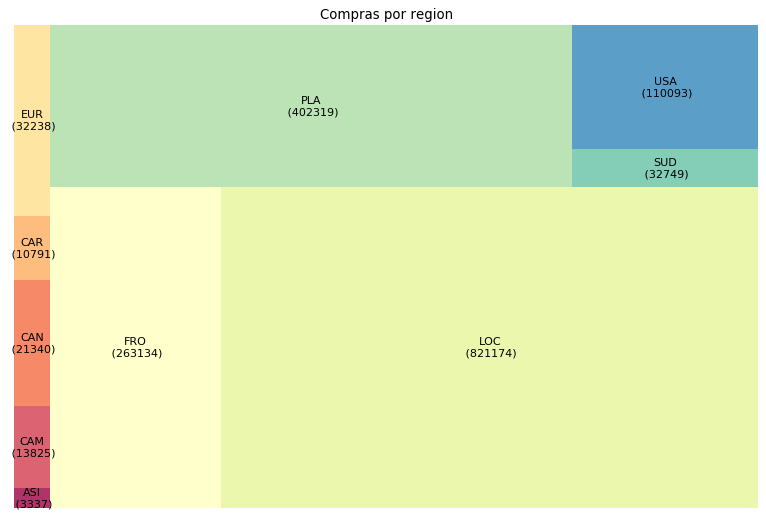

In [9]:
#Mapa de árbol para compras por región
# Prepare Data
df_group = df.groupby('regionCompra').size().reset_index(name='compras')
labels = df_group.apply(lambda x: str(x[0]) + "\n (" + str(x[1]) + ")", axis=1)
sizes = df_group['compras'].values.tolist()
colors = [plt.cm.Spectral(i/float(len(labels))) for i in range(len(labels))]

# Draw Plot
plt.figure(figsize=(12,8), dpi= 80)
squarify.plot(sizes=sizes, label=labels, color=colors, alpha=.8)

# Decorate
plt.title('Compras por region')
plt.axis('off')
plt.show()

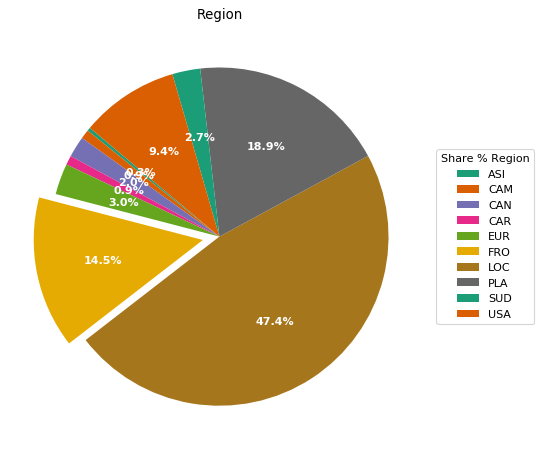

In [12]:
#Gráfica de Pastel de usuarios que sí compraron lo que buscaron por región
import numpy as np

in_true =  df['coincide'] == True
regiones_compra = df[in_true]
region_group = regiones_compra.groupby('regionCompra').size().reset_index(name='counts')
data = region_group['counts']
categories = region_group['regionCompra']
explode = [0,0,0,0,0,0.1,0,0,0,0]

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%".format(pct, absolute)
fig, ax = plt.subplots(figsize=(12, 7), subplot_kw=dict(aspect="equal"), dpi= 80)
wedges, texts, autotexts = ax.pie(data, 
                                  autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"), 
                                  colors=plt.cm.Dark2.colors,
                                 startangle=140,
                                 explode=explode)
ax.legend(wedges, categories, title="Share % Region", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.setp(autotexts, size=10, weight=700)
ax.set_title("Region")
plt.show()



In [ ]:
import pandas as pd
import seaborn as sns

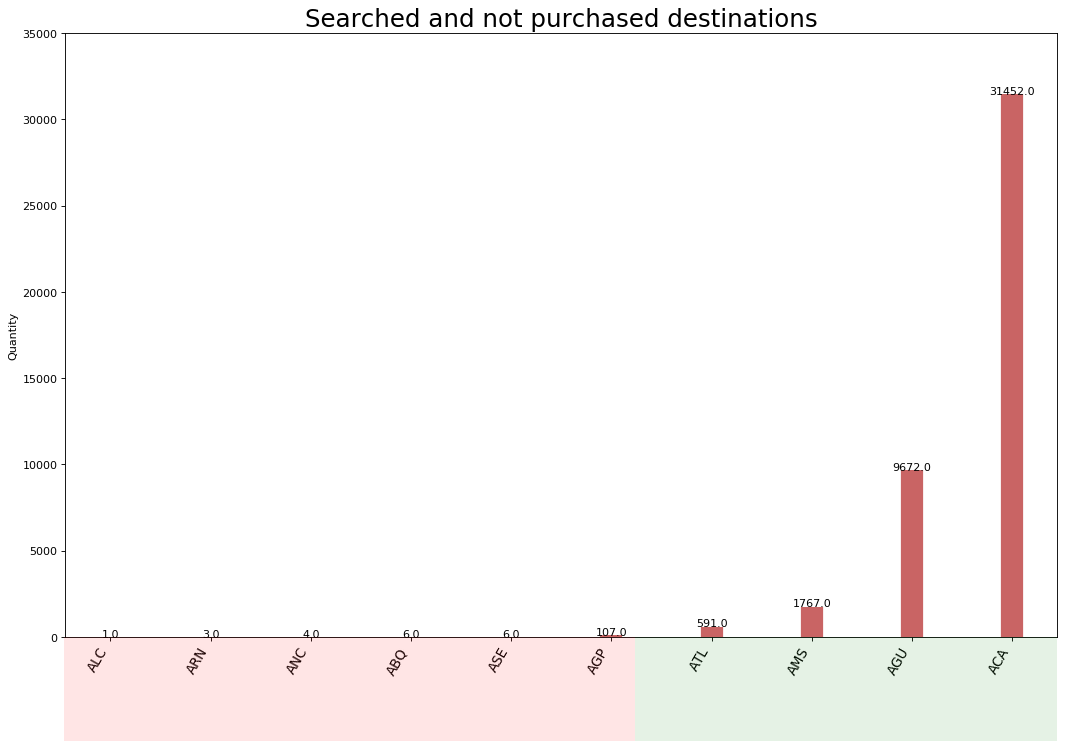

In [14]:
#Gráfica de barra que trae las coincidencias de búsquedas de las rutas que se buscan y poco se compran y
# de las búsquedas que no se buscan mucho pero no se compran

df_prueba = df[df['coincide'] != True]
df_P = df_prueba[df_prueba['destinoComprado'] != "MEX"]
df_group = df_P.groupby('destinoComprado').size().reset_index(name='counts')
top10=df_group.head(10)

# Prepare Data
df_g1= top10[['destinoComprado', 'counts']].groupby('destinoComprado').apply(lambda x: x.mean())
df_g1.sort_values('counts', inplace=True)
df_g1.reset_index(inplace=True)


fig, ax = plt.subplots(figsize=(16,10), facecolor='white', dpi= 80)
ax.vlines(x=df_g1.index, ymin=0, ymax=df_g1.counts, color='firebrick', alpha=0.7, linewidth=20)

# Annotate Text
for i, counts in enumerate(df_g1.counts):
    ax.text(i,counts+0.5, round(counts, 1), horizontalalignment='center')
    
# Draw plot
import matplotlib.patches as patches

# Title, Label, Ticks and Ylim
ax.set_title('Searched and not purchased destinations', fontdict={'size':22})
ax.set(ylabel='Quantity', ylim=(0, 35000))
plt.xticks(df_g1.index, df_g1.destinoComprado.str.upper(), rotation=60, horizontalalignment='right', fontsize=12)

# Add patches to color the X axis labels
p1 = patches.Rectangle((.57, -0.005), width=.33, height=.13, alpha=.1, facecolor='green', transform=fig.transFigure)
p2 = patches.Rectangle((.124, -0.005), width=.446, height=.13, alpha=.1, facecolor='red', transform=fig.transFigure)
fig.add_artist(p1)
fig.add_artist(p2)
plt.show()